# Установка зависимостей

In [ ]:
CUDA_CORE=1
# MODEL_USED="facebook/nllb-200-distilled-600M"
MODEL_USED="facebook/nllb-200-1.3B"
LANGUAGE_ORIGIN_LABEL="nivkh_Cyrl"
LANGUAGE_TARGET_LABEL="rus_Cyrl"
LANGUAGE_SIMILAR_LABEL="bak_Cyrl"
LANGUAGE_FILE_ORIGIN_LABEL="nivkh"
LANGUAGE_FILE_TARGET_LABEL="rus"
NORMALIZER_LANGUAGE="ru"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH="/content/drive/MyDrive/models/nllb_nivkh_rus_1.3B_base"
!mkdir -p {MODEL_SAVE_PATH}

In [ ]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [ ]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 126.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 128.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.33.0 which is incompatible.


In [ ]:
!pip install scikit-learn
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import seaborn as sns
from IPython.display import clear_output
from IPython.utils import io
import torch
import time
from torch import optim
from torch.nn import functional as F
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer
import shutil
import pickle
import os
import re

# Обработка данных

In [ ]:
input_dir = '/content/drive/MyDrive/translation_resplit3'
data = []

for filename in tqdm(os.listdir(input_dir)):
    if filename.endswith('.txt'):
        full_path = os.path.join(input_dir, filename)
        tag_match = re.search(r'_(\w+)\.txt$', filename)
        tag = tag_match.group(1) if tag_match else None
        with open(full_path, 'r', encoding='utf-8') as f:
            src, tgt = None, None
            for line in f:
                if re.match(r'^\d+>', line):
                    src = re.sub(r'^\d+>\s*', '', line).strip()
                elif re.match(r'^\d+=', line):
                    tgt = re.sub(r'^\d+=\s*', '', line).strip()
                    if src is not None:
                        data.append({
                            'nivkh': src,
                            'rus': tgt,
                            'file': filename,
                            'source': tag
                        })
                        src, tgt = None, None

df = pd.DataFrame(data)
df

  0%|          | 0/99 [00:00<?, ?it/s]

,nivkh,rus,file,source
0,Лаӄр̌.,Белка.,a185_tmn.txt,tmn
1,Ӄан лаӄр̌ ньр̌ыдь.,Собака белку увидела.,a185_tmn.txt,tmn
2,Лаӄр̌ ӄой сродь.,Белка на лиственницу забралась.,a185_tmn.txt,tmn
3,Ӄан ығдь.,Собака лает.,a185_tmn.txt,tmn
4,Ромкин лаӄр̌ амадь.,Ромкин на белку смотрит.,a185_tmn.txt,tmn
...,...,...,...,...
12123,Килгу йивдля?,Эвенки были?,11_shrsh.txt,shrsh
12124,"Келдох к’еспуртьғу, к’езотёстьғу.","Друг другу новости сообщают, спрашивают.",11_shrsh.txt,shrsh
12125,Ойӄра.,Грешно.,11_shrsh.txt,shrsh
12126,"Ойӄра, ойӄра, сидьвак фурдлю.","Грешно, грешно, всякое разное говорят.",11_shrsh.txt,shrsh


In [ ]:
df['nivkh_norm'] = df['nivkh'].str.lower().str.strip()
df['rus_norm'] = df['rus'].str.lower().str.strip()
df = df.drop_duplicates(subset=['nivkh_norm', 'rus_norm']).drop(columns=['nivkh_norm', 'rus_norm']).reset_index(drop=True)
df

,nivkh,rus,file,source
0,Лаӄр̌.,Белка.,a185_tmn.txt,tmn
1,Ӄан лаӄр̌ ньр̌ыдь.,Собака белку увидела.,a185_tmn.txt,tmn
2,Лаӄр̌ ӄой сродь.,Белка на лиственницу забралась.,a185_tmn.txt,tmn
3,Ӄан ығдь.,Собака лает.,a185_tmn.txt,tmn
4,Ромкин лаӄр̌ амадь.,Ромкин на белку смотрит.,a185_tmn.txt,tmn
...,...,...,...,...
11507,Килгу йивдля?,Эвенки были?,11_shrsh.txt,shrsh
11508,"Келдох к’еспуртьғу, к’езотёстьғу.","Друг другу новости сообщают, спрашивают.",11_shrsh.txt,shrsh
11509,Ойӄра.,Грешно.,11_shrsh.txt,shrsh
11510,"Ойӄра, ойӄра, сидьвак фурдлю.","Грешно, грешно, всякое разное говорят.",11_shrsh.txt,shrsh


In [ ]:
def restore_nivkh_capitalization(sents):
    capitalized_sents = []
    char_map = {
    'ӄ': 'Ӄ',
    'ӈ': 'Ӈ',
    'ӽ': 'Ӽ',
    'ғ': 'Ғ',
    'ҳ': 'Ҳ',
    'χ': 'Χ',
    'ӻ': 'Ӻ',
    'р̌': 'Р̌',
    'ӿ': 'Ӿ',
    'ў': 'Ў'
}
    for sent in sents:
        if not sent:
            capitalized_sents.append(sent)
            continue
        first_char = sent[0]
        rest_of_sent = sent[1:]
        if first_char in char_map.keys():
            capitalized_first = char_map[first_char]
        else:
            capitalized_first = first_char.upper()
        capitalized_sent = capitalized_first + rest_of_sent
        capitalized_sents.append(capitalized_sent)
    return capitalized_sents

In [ ]:
df['nivkh'] = restore_nivkh_capitalization(df['nivkh'])
df

,nivkh,rus,file,source
0,Лаӄр̌.,Белка.,a185_tmn.txt,tmn
1,Ӄан лаӄр̌ ньр̌ыдь.,Собака белку увидела.,a185_tmn.txt,tmn
2,Лаӄр̌ ӄой сродь.,Белка на лиственницу забралась.,a185_tmn.txt,tmn
3,Ӄан ығдь.,Собака лает.,a185_tmn.txt,tmn
4,Ромкин лаӄр̌ амадь.,Ромкин на белку смотрит.,a185_tmn.txt,tmn
...,...,...,...,...
11507,Килгу йивдля?,Эвенки были?,11_shrsh.txt,shrsh
11508,"Келдох к’еспуртьғу, к’езотёстьғу.","Друг другу новости сообщают, спрашивают.",11_shrsh.txt,shrsh
11509,Ойӄра.,Грешно.,11_shrsh.txt,shrsh
11510,"Ойӄра, ойӄра, сидьвак фурдлю.","Грешно, грешно, всякое разное говорят.",11_shrsh.txt,shrsh


In [ ]:
def clean_up(sents):
    map = {
        'ь:': 'ь.', 'Ē~ӽ': 'Ех', 'ѵ': 'у', 'Ē': 'Е', 'ā': 'а', 'ñ': '', '×': 'у',
        'ī': 'и', 'Ō': 'О', 'ō': 'о', 'р̃': 'р̌', 'р̆': 'р̌', '~': '-',
        '§.': '', 'ÿ': 'у', 'ʻ': '', 'ʼ': "'", 'р˘': 'р̌', 'р̀': 'р̌',
        '́': '', '̃': '', '̄': '', '̉': '', '̍': '', '̔': 'р', '̣': '',
        '̥': '', '̨': '', '̬': '', '̓': '', 'џ': 'ц', 'ґ': 'г', 'Ҥ': 'Ӈ',
        'Ң': 'Ӈ', 'ң': 'ӈ', 'Ӊ': 'Ӈ', 'ӊ': 'ӈ', 'ҧ': 'п', 'Ұ': 'ӻ',
        'ӗ': 'е', 'Өа х': 'Х', 'ӯ': 'у', 'ӱ': 'у', 'ӧ': 'ё', 'ҳ': 'х',
        '՚': "'", 'ḗ': 'е', 'ṓ': 'о', 'ṕ': 'р̌', '‑': '-', '‐': '-',
        '–': '-', '—': '-', '‘': "'", '’': "'", '“': '"', '”': '"',
        '«': '"', '»': '"', '•': '', '…': '...', '▸': '', 'Р̆': 'Р̌',
        'ē': 'е', 'Ӿ ': '! ', 'Ӿ" ': '!" ', "\\'": "'"
    }
    cleaned_sents = []
    for sent in sents:
        for old, new in map.items():
            sent = sent.replace(old, new)
        cleaned_sents.append(sent.replace("\\", ""))
    return cleaned_sents

In [ ]:
df['nivkh'] = clean_up(df['nivkh'])
df['rus'] = clean_up(df['rus'])
df

,nivkh,rus,file,source
0,Лаӄр̌.,Белка.,a185_tmn.txt,tmn
1,Ӄан лаӄр̌ ньр̌ыдь.,Собака белку увидела.,a185_tmn.txt,tmn
2,Лаӄр̌ ӄой сродь.,Белка на лиственницу забралась.,a185_tmn.txt,tmn
3,Ӄан ығдь.,Собака лает.,a185_tmn.txt,tmn
4,Ромкин лаӄр̌ амадь.,Ромкин на белку смотрит.,a185_tmn.txt,tmn
...,...,...,...,...
11507,Килгу йивдля?,Эвенки были?,11_shrsh.txt,shrsh
11508,"Келдох к'еспуртьғу, к'езотёстьғу.","Друг другу новости сообщают, спрашивают.",11_shrsh.txt,shrsh
11509,Ойӄра.,Грешно.,11_shrsh.txt,shrsh
11510,"Ойӄра, ойӄра, сидьвак фурдлю.","Грешно, грешно, всякое разное говорят.",11_shrsh.txt,shrsh


In [ ]:
# df.to_csv(LANGUAGE_FILE)
print(df.shape)
print(df.columns)

(11512, 4)
Index(['nivkh', 'rus', 'file', 'source'], dtype='object')


In [ ]:
sources = list(set(df['source']))
sources

['srhsh', 'bible', 'tmn', 'ptmn', 'gdn', 'sng', 'grz', 'shrsh', 'shtrn', 'pnf']

In [ ]:
df_train, df_devtest = train_test_split(df, test_size=0.2, random_state=42, stratify=df['source'])
df_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=42, stratify=df_devtest['source'])

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9209 entries, 708 to 10736
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   nivkh   9209 non-null   object
 1   rus     9209 non-null   object
 2   file    9209 non-null   object
 3   source  9209 non-null   object
dtypes: object(4)
memory usage: 359.7+ KB


In [ ]:
df_train.head()

,nivkh,rus,file,source
708,Озир̌ ындыйa.,"Встань, посмотри.",a141_shtrn.txt,shtrn
1199,Ӿо-о.,"О, о, о.",a139_shtrn.txt,shtrn
7268,Ӿымдир̌ к'ымлыд.,Так вот придумал.,a462_sng.txt,sng
8038,Ығмиф палхина:,Ыгмифа гора :,a462_sng.txt,sng
2415,"Иф к'рыу т'агрух миф, хитф лығр, мокрть.","Пока он отдыхал, землю, где острова не было, р...",a129_gdn.txt,gdn


In [ ]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1151 entries, 7844 to 7444
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   nivkh   1151 non-null   object
 1   rus     1151 non-null   object
 2   file    1151 non-null   object
 3   source  1151 non-null   object
dtypes: object(4)
memory usage: 45.0+ KB


In [ ]:
df_dev.head()

,nivkh,rus,file,source
7844,Мирн р̌амтигн к'ымлыд яғзуйдхун ар ло? -,Наши думы разве не узнают? -,a462_sng.txt,sng
1588,Тух хывӈ урд.,Топор хорошо рубит.,a225_grz.txt,grz
1853,Ытык ӿивс т'ыпрдь.,Отец березу принес.,a193_tmn.txt,tmn
11127,Р̌атғлу вийныӈан т'ылфтох.,Когда куда нибудь далеко.,11_shrsh.txt,shrsh
8885,Чыӈух к'ыск йивдь.,У вас кошка есть.,a226_tmn.txt,tmn


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1152 entries, 5586 to 3190
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   nivkh   1152 non-null   object
 1   rus     1152 non-null   object
 2   file    1152 non-null   object
 3   source  1152 non-null   object
dtypes: object(4)
memory usage: 45.0+ KB


In [ ]:
df_test.head()

,nivkh,rus,file,source
5586,Чи наф нерӽарр̌ пуйны ло?,"Ты, меня осилив, взлетишь ли?",a462_sng.txt,sng
4507,Туд урла мурӈ.,Это хорошая лошадь.,a228_grz.txt,grz
10015,Тилэ ӿат лель.,Качнулась так.,30_shrsh.txt,shrsh
6588,Авгун чунь-сӽар̌кун,Достойных чунь-деревья -,a462_sng.txt,sng
10433,"Ӿоӄор̌, ӿоӈгур̌, полмғытр̌, йымык лу йытик лу ...","Затем пришли то ли её мать, то ли отец, повели...",22_shrsh.txt,shrsh


# Настройка модели

## Настройка токенизатора

In [ ]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [ ]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

In [ ]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [ ]:
smpl = df_train.sample(10000, random_state=42, replace=True)
smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_toks'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(tokenizer.tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_toks'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(tokenizer.tokenize)

smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_words'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(word_tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_words'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(word_tokenize)

In [ ]:
smpl.sample(5)[[LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_toks']]

,nivkh,nivkh_words,nivkh_toks,rus,rus_words,rus_toks
3517,Нуғи иғ чо.,"[Нуғи, иғ, чо, .]","[▁Ну, ғи, ▁иғ, ▁чо, .]",Первая пойманная рыба.,"[Первая, пойманная, рыба, .]","[▁Пер, вая, ▁пой, ман, ная, ▁ры, ба, .]"
11017,Лувр ӈалағытк тиғр толух тоӈгут вилвилкур.,"[Лувр, ӈалағытк, тиғр, толух, тоӈгут, вилвилку...","[▁Лу, вр, ▁, ӈ, ала, ғы, тк, ▁ти, ғ, р, ▁то, л...","Палка, похожая на ложку, в воде вот так виляет.","[Палка, ,, похожая, на, ложку, ,, в, воде, вот...","[▁П, ал, ка, ,, ▁похо, жа, я, ▁на, ▁ло, жку, ,..."
5245,Ӿалве!,"[Ӿалве, !]","[▁, Ӿ, ал, ве, !]",Давайте же!,"[Давайте, же, !]","[▁Давайте, ▁же, !]"
9668,Ӿағитлы нерӽ п'ырвыринакан.,"[Ӿағитлы, нерӽ, п, ', ырвыринакан, .]","[▁, Ӿ, а, ғи, т, лы, ▁нер, ӽ, ▁п, ', ыр, вы, р...","Конечно, она на меня будет нападать.","[Конечно, ,, она, на, меня, будет, нападать, .]","[▁Конечно, ,, ▁она, ▁на, ▁меня, ▁будет, ▁напад..."
10530,Во фиӈгу ат ир̌тьғу чиған оғлагу пандь ӿавур.,"[Во, фиӈгу, ат, ир, ̌, тьғу, чиған, оғлагу, па...","[▁Во, ▁фи, ӈ, гу, ▁ат, ▁ир, ̌, ть, ғу, ▁чи, ға...","Люди с соседнего стойбища сказали мне, что ты ...","[Люди, с, соседнего, стойбища, сказали, мне, ,...","[▁Люди, ▁с, ▁сосе, дне, го, ▁стой, би, ща, ▁ск..."


In [ ]:
stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()
stats

<ipython-input-29-8bf0a8236e3f>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()


,nivkh_toks,rus_toks,nivkh_words,rus_words
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,16.163800,11.138500,7.904300,7.136300
std,10.654122,7.296947,5.264192,4.559671
min,2.000000,2.000000,1.000000,1.000000
25%,9.000000,7.000000,4.000000,4.000000
50%,14.000000,9.000000,7.000000,6.000000
75%,19.000000,13.000000,10.000000,9.000000
max,131.000000,92.000000,65.000000,57.000000


In [ ]:
print(stats[LANGUAGE_FILE_ORIGIN_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_ORIGIN_LABEL + "_words"]['mean'])
print(stats[LANGUAGE_FILE_TARGET_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_TARGET_LABEL + "_words"]['mean'])

2.044937565628835
1.560822835362863


In [ ]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


In [ ]:
texts_with_unk = [text for text in tqdm(df[LANGUAGE_FILE_TARGET_LABEL]) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/11512 [00:00<?, ?it/s]

30


In [ ]:
import random
s = random.sample(texts_with_unk, 5)
s

['Моя старшая сестра Чӈырк телят кормит.',
 'Наӻвгун и Сыйдин бурундука искать пошли.',
 'Чиӈ - так слушал',
 'Тогда Наӻвгун просто закричал:',
 'Своему ызӈ-хозяину в рот брось-ка!" -']

In [ ]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang=NORMALIZER_LANGUAGE)
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [ ]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

  0%|          | 0/30 [00:00<?, ?it/s]

30


## Расширение словаря

In [ ]:
from collections import Counter
all_texts = df[LANGUAGE_FILE_TARGET_LABEL]
all_text_normalized = [preproc(t) for t in tqdm(all_texts)]
chars_cnt = Counter(c for t in all_text_normalized for c in t)
required_chars = ''.join([
    k for k, v in chars_cnt.most_common()
    if v >= 3 and k not in ' '
])

  0%|          | 0/11512 [00:00<?, ?it/s]

In [ ]:
all_texts_file = MODEL_SAVE_PATH + "/all_texts_file.csv"
df[LANGUAGE_FILE_TARGET_LABEL].to_csv(all_texts_file, sep='|', index=False, header=False)

In [ ]:
import sentencepiece as spm

SPM_PREFIX = MODEL_SAVE_PATH + '/spm_16k'
with open(all_texts_file, 'w') as f:
    for i, text in enumerate(all_texts):
        print(text, file=f)

spm.SentencePieceTrainer.train(
    input=all_texts_file,
    model_prefix=SPM_PREFIX,
    vocab_size=8933,  # 16K
    character_coverage = 1,
    num_threads=16,
    train_extremely_large_corpus=False,
    add_dummy_prefix=False,
    max_sentencepiece_length=128,
    max_sentence_length=4192*4,
    pad_id=0,
    eos_id=1,
    unk_id=2,
    bos_id=-1,
    required_chars=required_chars,
)

In [ ]:
# !pip install protobuf==3.19.4 --force-reinstall

In [ ]:
# !wget https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py -O /home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py

In [ ]:
from sentencepiece import sentencepiece_model_pb2 as sp_pb2_model
# At this step, the code may throw an error about protobuf. Do as it tells.
from transformers import NllbTokenizer

# reading the NLLB and the Tyvan sentencepiece models into a native format
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
sp_trained = spm.SentencePieceProcessor(model_file=f'{SPM_PREFIX}.model')
added_spm = sp_pb2_model.ModelProto()
added_spm.ParseFromString(sp_trained.serialized_model_proto())
old_spm = sp_pb2_model.ModelProto()
old_spm.ParseFromString(tokenizer.sp_model.serialized_model_proto())

# adding the missing tokens to the NLLB sentencepiece model
nllb_tokens_set = {p.piece for p in old_spm.pieces}
prev_min_score = old_spm.pieces[-1].score
for p in added_spm.pieces:
    piece = p.piece
    if piece not in nllb_tokens_set:
        new_p = sp_pb2_model.ModelProto().SentencePiece()
        new_p.piece = piece
        # for all new tokens, I'll set a lower score (priority)
        new_p.score = p.score + prev_min_score
        old_spm.pieces.append(new_p)

# saving the result to disk
NEW_SPM_NAME = MODEL_SAVE_PATH + '/spm_nllb_268k.model'
with open(NEW_SPM_NAME, 'wb') as f:
    f.write(old_spm.SerializeToString())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
from transformers import AutoModelForSeq2SeqLM
model_name = MODEL_USED

# loading the tokenizers
tokenizer_old = NllbTokenizer.from_pretrained(model_name)
tokenizer = NllbTokenizer.from_pretrained(model_name, vocab_file=NEW_SPM_NAME)
print(len(tokenizer_old), len(tokenizer)) # 256204, 263178
added_vocab = set(tokenizer.get_vocab()).difference(set(tokenizer_old.get_vocab()))
print(len(added_vocab))  # 6973

# loading and resizing the model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# re-initializing the new embeddings
for t in tqdm(added_vocab):
    tt = tokenizer_old(t, add_special_tokens=False).input_ids
    if len(tt) == 0:
        tt = [tokenizer_old.unk_token_id]
    idx = tokenizer.convert_tokens_to_ids(t)
    model.model.shared.weight.data[idx] = model.model.shared.weight.data[tt].mean(0)

256204 263178
6973


config.json:   0%|          | 0.00/808 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/5.48G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 263178. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


  0%|          | 0/6973 [00:00<?, ?it/s]

## Добавление тэга нового языка в токенизатор и модель

In [ ]:
print('nivkh_Cyrl' in tokenizer.get_vocab())
print('rus_Cyrl' in tokenizer.get_vocab())

False
True


In [ ]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [ ]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_ORIGIN_LABEL):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [ ]:
fix_tokenizer(tokenizer)

In [ ]:
print(tokenizer.convert_ids_to_tokens([263176, 263177, 263178])) # ['zul_Latn', 'tyv_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'nivkh_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'nivkh_Cyrl', '<mask>']
[263176, 263177, 263178]


In [ ]:
added_token_id = tokenizer.convert_tokens_to_ids(LANGUAGE_TARGET_LABEL)
similar_lang_id = tokenizer.convert_tokens_to_ids(LANGUAGE_SIMILAR_LABEL)
print(added_token_id, similar_lang_id)

263121 262995


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_USED)
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 263179. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(263179, 1024)

In [ ]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

# Обучение (L4)

##  Предварительные шаги

In [ ]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_SAVE_PATH).to('cuda')
tokenizer = NllbTokenizer.from_pretrained(MODEL_SAVE_PATH)
fix_tokenizer(tokenizer)

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [ ]:
batch_size = 16 # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1000
training_steps = 27000

In [ ]:
import json

losses = []
with open('/content/drive/MyDrive/models/nllb_nivkh_rus_1.3B_base/losses.json') as json_file:
    losses = json.load(json_file)
losses

[8.675296783447266,
 8.17028522491455,
 8.029876708984375,
 7.6340107917785645,
 8.496322631835938,
 8.875389099121094,
 8.408841133117676,
 9.133420944213867,
 8.60214900970459,
 9.697440147399902,
 8.63015365600586,
 8.320165634155273,
 8.151701927185059,
 7.880644798278809,
 8.341656684875488,
 8.0016508102417,
 7.874567031860352,
 9.554542541503906,
 8.653656959533691,
 8.785233497619629,
 7.5609893798828125,
 8.313130378723145,
 7.843294143676758,
 7.424382209777832,
 7.996669769287109,
 8.235403060913086,
 7.949558258056641,
 8.628564834594727,
 7.897469997406006,
 8.38625431060791,
 7.5922088623046875,
 8.347794532775879,
 8.14907169342041,
 8.752480506896973,
 7.70561408996582,
 8.721595764160156,
 7.6059441566467285,
 8.193005561828613,
 7.649867057800293,
 8.499677658081055,
 8.336804389953613,
 7.382980823516846,
 8.01136302947998,
 7.599798679351807,
 8.528376579284668,
 8.009998321533203,
 8.481929779052734,
 7.407018184661865,
 8.246288299560547,
 8.056442260742188,
 8.02

In [ ]:
# losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [ ]:
LANGS = [(LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_ORIGIN_LABEL), (LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_TARGET_LABEL)]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(['Из травы вытащив, спустили.'], ['Чӈырух сиур̌ ӻоть фуру.'], 'rus_Cyrl', 'nivkh_Cyrl')


## Циклы обучения (в тренировочных шагах)

In [ ]:
#@title 0-15k

import json
import os

LOSS_FILE = os.path.join(MODEL_SAVE_PATH, "losses.json")

model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        if i % 100 == 0:
            with open(LOSS_FILE, 'w') as f:
                json.dump(losses, f)

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

with open(LOSS_FILE, 'w') as f:
    json.dump(losses, f)

  0%|          | 0/15000 [00:00<?, ?it/s]

0 8.675296783447266
1000 4.8572722842693326
2000 2.7256458200216294
3000 2.062479882955551
4000 1.6257602400183677
5000 1.2599347133040428
6000 0.9822730516195297
7000 0.7812718825787306
8000 0.592057792186737
9000 0.4860722786337137
10000 0.38380657529085876
11000 0.3150577996224165
12000 0.2604606680236757
13000 0.2164437010306865
14000 0.17902636305242778


In [ ]:
#@title 15-24k

import json
import os

LOSS_FILE = os.path.join(MODEL_SAVE_PATH, "losses.json")

model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        if i % 100 == 0:
            with open(LOSS_FILE, 'w') as f:
                json.dump(losses, f)

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

with open(LOSS_FILE, 'w') as f:
    json.dump(losses, f)

  0%|          | 0/10000 [00:00<?, ?it/s]

15000 0.15176515592448414
16000 0.12876421112380923
17000 0.10948896624334156
18000 0.09691781223472208
19000 0.08778730978164821
20000 0.07881242106575519
21000 0.07107551285997032
22000 0.06512560481671244
23000 0.060726642983034256
24000 0.05918576078070328


In [ ]:
#@title 24-27k

import json
import os

LOSS_FILE = os.path.join(MODEL_SAVE_PATH, "losses.json")

model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        if i % 100 == 0:
            with open(LOSS_FILE, 'w') as f:
                json.dump(losses, f)

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

with open(LOSS_FILE, 'w') as f:
    json.dump(losses, f)

  0%|          | 0/2999 [00:00<?, ?it/s]

25000 0.04542179464735091
26000 0.05554841751465574


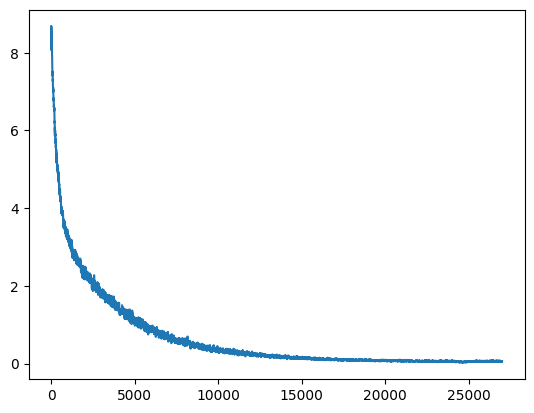

In [ ]:
pd.Series(losses).ewm(10).mean().plot();

In [ ]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [ ]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['свой ящик открыл, серебряную фигуру одну взяв повесил.']
['Пфахей аллыхыр̌, тота-чхнай нан гер̌ реврa.']
['Пшахт алскун, тота-чхнай нан гер̌ реврa.']


In [ ]:
!ls -alsh $MODEL_SAVE_PATH

total 5.2G
673K -rw------- 1 root root 673K May 29 20:49 all_texts_file.csv
1.0K -rw------- 1 root root  880 May 30 05:32 config.json
 512 -rw------- 1 root root  184 May 30 05:32 generation_config.json
4.0K drwx------ 2 root root 4.0K May 29 20:57 .ipynb_checkpoints
541K -rw------- 1 root root 541K May 30 05:50 losses.json
5.2G -rw------- 1 root root 5.2G May 30 05:32 pytorch_model.bin
4.8M -rw------- 1 root root 4.8M May 30 04:33 sentencepiece.bpe.model
3.5K -rw------- 1 root root 3.5K May 30 05:32 special_tokens_map.json
418K -rw------- 1 root root 418K May 29 20:49 spm_16k.model
193K -rw------- 1 root root 193K May 29 20:49 spm_16k.vocab
4.8M -rw------- 1 root root 4.8M May 29 20:49 spm_nllb_268k.model
1.0K -rw------- 1 root root  570 May 30 05:32 tokenizer_config.json


# Тестирование

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [ ]:
def batched_translate(texts, batch_size=8, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [ ]:
df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = [translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_TARGET_LABEL])]
df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = [translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_ORIGIN_LABEL])]

  0%|          | 0/1152 [00:00<?, ?it/s]

  0%|          | 0/1152 [00:00<?, ?it/s]

In [ ]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)

In [ ]:
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))

BLEU = 10.74 40.1/13.8/6.9/4.1 (BP = 0.961 ratio = 0.962 hyp_len = 6310 ref_len = 6558)
chrF2++ = 31.08
BLEU = 17.77 47.5/21.6/13.2/8.3 (BP = 0.970 ratio = 0.970 hyp_len = 7886 ref_len = 8127)
chrF2++ = 35.79


In [ ]:
df_test['source'] = df_test['source'].str.replace('srhsh', 'shrsh', regex=False)

In [ ]:
from collections import defaultdict

# метрики по источникам
scores = defaultdict(dict)
for src, df in df_test.groupby('source'):
    # rus --> nivkh
    refs_n2r = [df[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]
    preds_n2r = df[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist()
    scores[src]['bleu_NR'] = bleu_calc.corpus_score(preds_n2r, refs_n2r)
    scores[src]['chrf_NR'] = chrf_calc.corpus_score(preds_n2r, refs_n2r)
    # nivkh --> rus
    refs_r2n = [df[LANGUAGE_FILE_TARGET_LABEL].tolist()]
    preds_r2n = df[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist()
    scores[src]['bleu_RN'] = bleu_calc.corpus_score(preds_r2n, refs_r2n)
    scores[src]['chrf_RN'] = chrf_calc.corpus_score(preds_r2n, refs_r2n)

for src, s in scores.items():
    print(src)
    print('--------')
    for name, val in s.items():
        print(f'{name}: {val}')
    print()

# перепутаны NR и RN

bible
--------
bleu_NR: BLEU = 3.40 34.8/4.9/1.4/0.8 (BP = 0.917 ratio = 0.920 hyp_len = 46 ref_len = 50)
chrf_NR: chrF2++ = 27.38
bleu_RN: BLEU = 4.71 34.8/4.9/2.8/1.6 (BP = 0.897 ratio = 0.902 hyp_len = 46 ref_len = 51)
chrf_RN: chrF2++ = 19.56

gdn
--------
bleu_NR: BLEU = 1.43 27.7/1.1/0.7/0.4 (BP = 0.837 ratio = 0.849 hyp_len = 101 ref_len = 119)
chrf_NR: chrF2++ = 16.73
bleu_RN: BLEU = 3.28 29.4/7.1/1.0/0.6 (BP = 0.992 ratio = 0.992 hyp_len = 126 ref_len = 127)
chrf_RN: chrF2++ = 18.28

grz
--------
bleu_NR: BLEU = 36.43 62.7/33.0/28.6/33.3 (BP = 0.972 ratio = 0.973 hyp_len = 142 ref_len = 146)
chrf_NR: chrF2++ = 49.35
bleu_RN: BLEU = 49.34 72.8/48.4/43.3/40.7 (BP = 0.988 ratio = 0.988 hyp_len = 162 ref_len = 164)
chrf_RN: chrF2++ = 60.55

pnf
--------
bleu_NR: BLEU = 8.70 34.4/10.2/5.4/3.0 (BP = 1.000 ratio = 1.013 hyp_len = 637 ref_len = 629)
chrf_NR: chrF2++ = 27.41
bleu_RN: BLEU = 13.45 49.0/18.3/9.2/5.0 (BP = 0.945 ratio = 0.946 hyp_len = 847 ref_len = 895)
chrf_RN: chrF2++ 

In [ ]:
pd.options.display.max_colwidth = 100

In [ ]:
df_test.sample(30, random_state=100)[[LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_translated', LANGUAGE_FILE_ORIGIN_LABEL + '_translated']]

,rus,nivkh,rus_translated,nivkh_translated
8357,"А то-о-от человек,",Т'афк,Недавно,"А те-и-и нивӈа,"
7392,"Мы все на женщин похожи будем, -","Мен сик р̌аӈӷ вотияӄна, -","- Вознамерились они, -","Мирн сык р̌аӈӷхун вотира, -"
1565,Отец тоже слушает.,Ытк ан мыд.,Отец тоже слушает.,Ытык ан мыд.
7918,"Отдал им, оказывается.",Ирна химд фуру.,Им отдал отдал.,Иғмве фуру.
7627,"Если возразить, разве не придут?","Керӈат т'а п'р̌ыӽари ло,","Если возразить, разве не придут в сторону двери?",Керӈат керӻойдғун ло.
10488,"Села, стала доить грудь на руки.",Ӿоӈгур ӿуртивр мытик тымкрох ӻаврур.,"Так сидела, бабушка, не рукой.","Ӿуртивр̌, тиғр̌кир̌к вор̌."
7746,"Куру-у-у, подходит, оказывается -","Куру-у-у - п'рыйвы фуру, -","Куру-у-у - прибыли, -",Куру-у-у п'р̌ыӻар вуру! -
2834,"Ну, давайте, вместе пойдем.","Ӿелве, угрыхарын винтa.","Давайте, вместе пойдем.","Ӿалве, ухмунтa."
7733,"Наш товарищ, ищущий женщину который,",Мен ӈафӄ аньӻай нанӻад эр̌ӄ,"Наш товарищ, нас жалея,","Мен ӈафӄа, ӈафӄа иньӻар̌,"
10994,"Они спрашивают, а я на своем языке только говорю.","Имӈ ётьётьғар, ни п'ситр̌ пак итт.",Я на своем языке только говорю.,Имғу пар̌к п'ситр̌ итныӄан.


# Сохранение на HF

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
The token `4exam` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `4exam`


In [ ]:
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig

model_load_name = "/content/drive/MyDrive/models/nllb_nivkh_rus_1.3B_base"
cfg = AutoConfig.from_pretrained(model_load_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name, config=cfg)
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
upload_repo = "nllb_nivkh_rus_1.3B_base"
tokenizer.push_to_hub(upload_repo)
model.push_to_hub(upload_repo)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sentencepiece.bpe.model:   0%|          | 0.00/5.01M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.51G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/el-izm/nllb_nivkh_rus_1.3B_base/commit/f2d8b2cb9cdf9292e69939fd7fa383e4c90c3d68', commit_message='Upload M2M100ForConditionalGeneration', commit_description='', oid='f2d8b2cb9cdf9292e69939fd7fa383e4c90c3d68', pr_url=None, repo_url=RepoUrl('https://huggingface.co/el-izm/nllb_nivkh_rus_1.3B_base', endpoint='https://huggingface.co', repo_type='model', repo_id='el-izm/nllb_nivkh_rus_1.3B_base'), pr_revision=None, pr_num=None)